# Dimensionality Reduction Evaluation
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate dimensionality reduction techniques for their ability to preserve Euclidean structure of high-dimensional datasets.__  
  
To benchmark these techniques, we are using two single-cell RNAseq datasets:
* From [__Macosko, *et al* (2015)__](https://www.ncbi.nlm.nih.gov/pubmed/26000488), the mouse retina scRNA-seq data generated using DropSeq: [GSM1626793](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1626793)
* From [__Herring, *et al* (2018)__](https://www.ncbi.nlm.nih.gov/pubmed/29153838), the WT mouse colon scRNA-seq data generated using inDrops: [GSM2743164](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2743164)  
  
The first set should be __discrete__, containing highly separable cell populations from the mouse retina, where the latter will be __continuous__, representing a continuum of branching cell states in the gut epithelium.  
  
Both datasets have been __preprocessed and feature-selected__ to allow for direct input to downstream dimensionality reduction algorithms (rather than first performing PCA to limit dimensional input). These methods are shown in [`dev/QC.ipynb`](dev/QC.ipynb).

In [2]:
import sys
sys.path.append('../')
from fcc_DRs import *
%matplotlib inline

FIt-SNE repository not detected. Functionality will be disabled.


In [167]:
# reload functions when editing file
del sys.modules['fcc_DRs']
from fcc_DRs import *

In [3]:
# read in Macosko retina data
retina = RNA_counts.from_file('../inputs/GSM1626793_P14Retina_1.processed.tsv', cells_axis=0, labels=[0,0])
# read in Herring colon data
colon = RNA_counts.from_file('../inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv', cells_axis=0, labels=[0,0])

In [4]:
# look at dimensions of counts matrix (cells, genes)
retina.data.shape

(1326, 500)

In [5]:
# look at dimensions of counts matrix (cells, genes)
colon.data.shape

(1117, 500)

---
### PCA
We'll look at principal component analysis (PCA) first, as a gold-standard. Because PCA performs a __linear__ transformation on the data, 500 PCs should perfectly preserve the overall dataset structure.

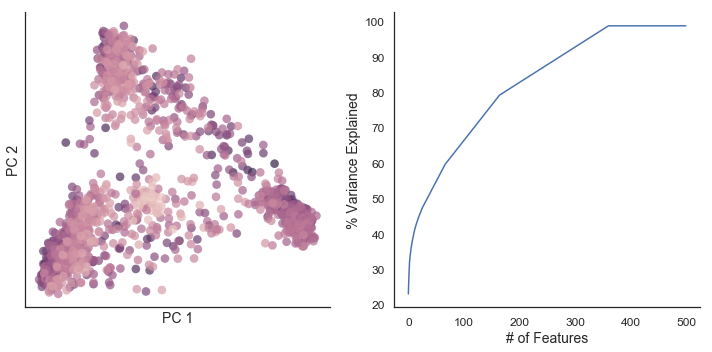

In [5]:
retina_PCA500 = fcc_PCA(retina.arcsinh_norm(), n_components=500)
retina_PCA500.plot_PCA()

We can test the Euclidean distance preservation as follows:

In [6]:
# choose value for K-nearest neighbor calculations. We use 30 because that is the standard perplexity chosen for DR techniques here.
k = 30

/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


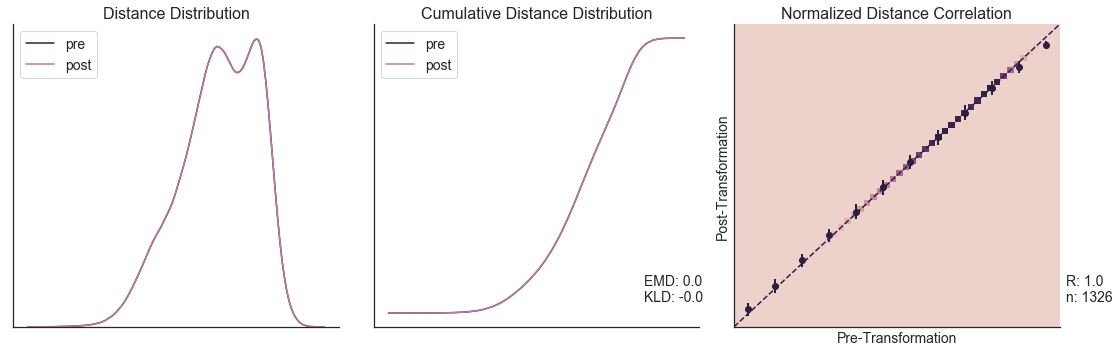

Knn Pres.: 100.0
CPU times: user 43.5 s, sys: 8.03 s, total: 51.5 s
Wall time: 51.3 s


In [7]:
%%time
mantel_stats, EMD, KLD = compare_euclid(pre=retina.distance_matrix(transform='arcsinh'), post=retina_PCA500.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_PCA500.knn_graph(k))
print('Knn Pres.: {}'.format(round(knn, 4)))

Now we can perform a PCA with a smaller number of components and determine the degree of information loss.  
The extreme example would be comparing only the __first two principal components__ to the original dataset:

In [7]:
# create dictionaries for dumping results into
final_distance_stats = {'Retina':{'R':{}, 'EMD':{}, 'KLD':{}, 'Knn Pres.':{}}, 'Colon':{'R':{}, 'EMD':{}, 'KLD':{}, 'Knn Pres.':{}}}

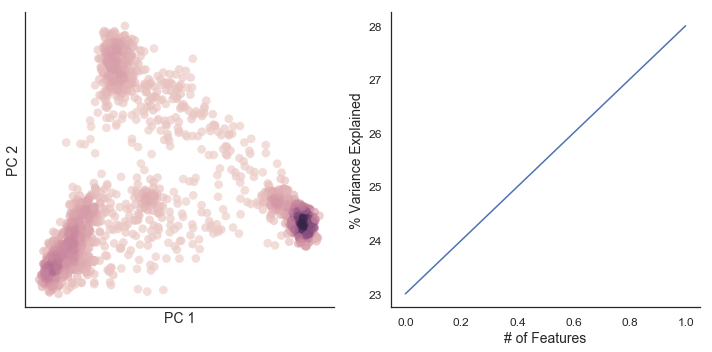

In [9]:
retina_PCA2 = fcc_PCA(retina.arcsinh_norm(), n_components=2)
retina_PCA2.plot_PCA()

In [20]:
retina_PCA2.plot(color=retina.arcsinh_norm().sum(axis=1), save_to='images/retina_PCA.png', figsize=(6,6))

In [10]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_PCA2.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_PCA2.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['PCA (2)'], final_distance_stats['Retina']['EMD']['PCA (2)'], final_distance_stats['Retina']['KLD']['PCA (2)'], final_distance_stats['Retina']['Knn Pres.']['PCA (2)'] = mantel_stats[0], EMD, KLD, knn

R: 0.7718
EMD: 0.2231
KLD: 0.1929
Knn Pres.: 96.7996
CPU times: user 36.7 s, sys: 6.74 s, total: 43.5 s
Wall time: 43.8 s


CPU times: user 18.9 s, sys: 418 ms, total: 19.3 s
Wall time: 18.7 s


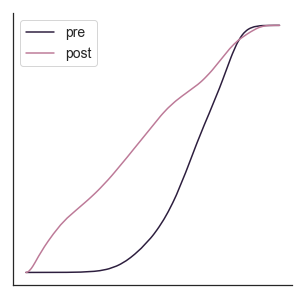

<Figure size 504x504 with 0 Axes>

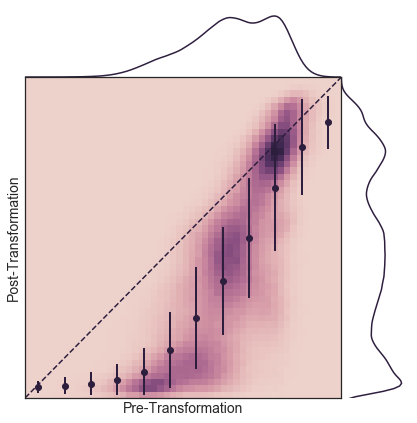

In [11]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_PCA2_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_PCA2_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

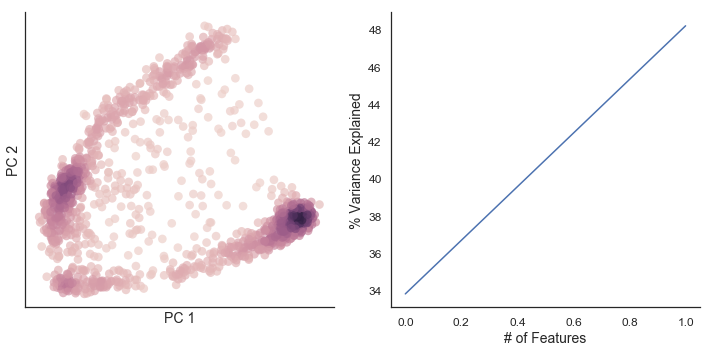

In [12]:
colon_PCA2 = fcc_PCA(colon.arcsinh_norm(), n_components=2)
colon_PCA2.plot_PCA()

In [13]:
colon_PCA2.plot(color=colon.arcsinh_norm().sum(axis=1), save_to='images/colon_PCA.png', figsize=(6,6))

In [14]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_PCA2.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_PCA2.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['PCA (2)'], final_distance_stats['Colon']['EMD']['PCA (2)'], final_distance_stats['Colon']['KLD']['PCA (2)'], final_distance_stats['Colon']['Knn Pres.']['PCA (2)'] = mantel_stats[0], EMD, KLD, knn

R: 0.9381
EMD: 0.0635
KLD: 0.0594
Knn Pres.: 97.529
CPU times: user 24 s, sys: 4.25 s, total: 28.3 s
Wall time: 28.5 s


CPU times: user 18.6 s, sys: 468 ms, total: 19 s
Wall time: 18.6 s


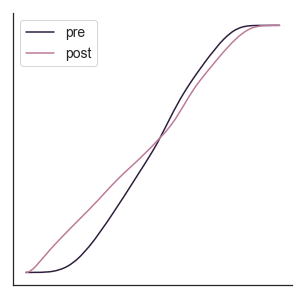

<Figure size 504x504 with 0 Axes>

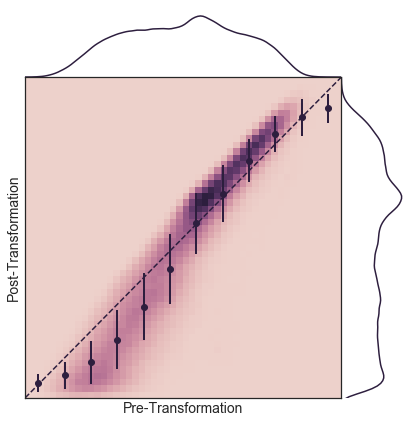

In [15]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_PCA2_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_PCA2_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

Now let's do __10 PCs__ to compare to __scVI__ output, which is the only DR method we have that can't return a 2D embedding:

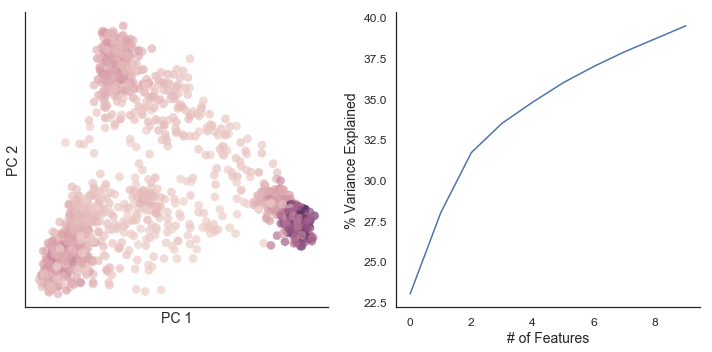

In [16]:
retina_PCA10 = fcc_PCA(retina.arcsinh_norm(), n_components=10)
retina_PCA10.plot_PCA()

In [17]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_PCA10.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_PCA10.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['PCA (10)'], final_distance_stats['Retina']['EMD']['PCA (10)'], final_distance_stats['Retina']['KLD']['PCA (10)'], final_distance_stats['Retina']['Knn Pres.']['PCA (10)'] = mantel_stats[0], EMD, KLD, knn

R: 0.8557
EMD: 0.166
KLD: 0.0544
Knn Pres.: 97.4039
CPU times: user 37.8 s, sys: 7.22 s, total: 45.1 s
Wall time: 45.3 s


CPU times: user 18.8 s, sys: 473 ms, total: 19.3 s
Wall time: 18.9 s


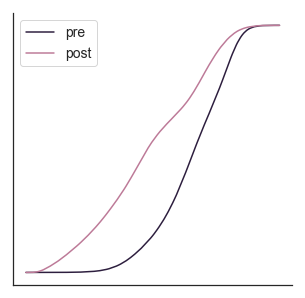

<Figure size 504x504 with 0 Axes>

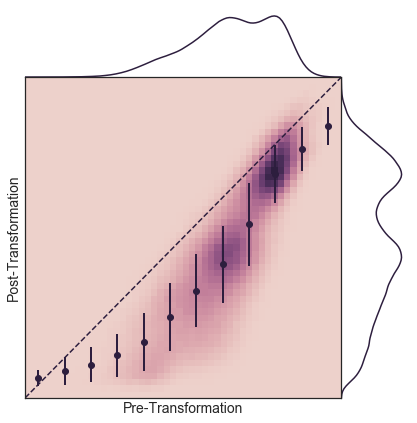

In [18]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_PCA10_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_PCA10_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

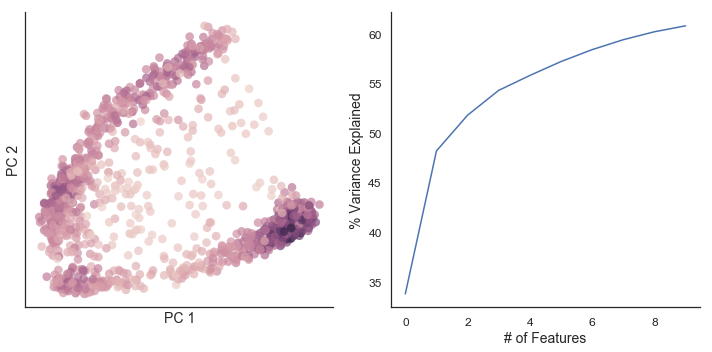

In [19]:
colon_PCA10 = fcc_PCA(colon.arcsinh_norm(), n_components=10)
colon_PCA10.plot_PCA()

In [22]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_PCA10.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_PCA10.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['PCA (10)'], final_distance_stats['Colon']['EMD']['PCA (10)'], final_distance_stats['Colon']['KLD']['PCA (10)'], final_distance_stats['Colon']['Knn Pres.']['PCA (10)'] = mantel_stats[0], EMD, KLD, knn

R: 0.9688
EMD: 0.0375
KLD: 0.0101
Knn Pres.: 98.0708
CPU times: user 24.5 s, sys: 5.11 s, total: 29.6 s
Wall time: 29.8 s


CPU times: user 18.8 s, sys: 494 ms, total: 19.3 s
Wall time: 19 s


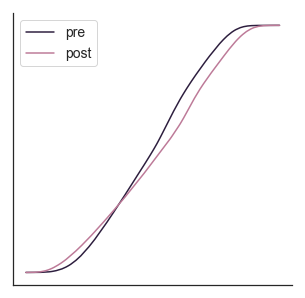

<Figure size 504x504 with 0 Axes>

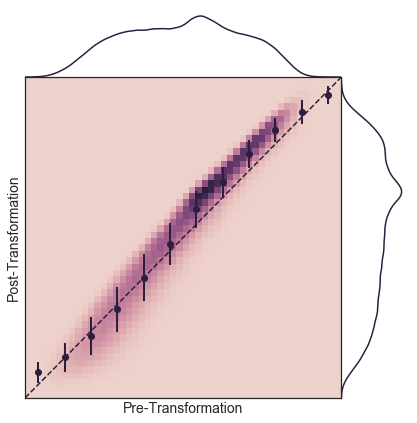

In [23]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_PCA10_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_PCA10_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# t-SNE
A workhorse technique for dimensionality reduction and visualization of scRNA-seq datasets, t-SNE performs a stochastic, non-linear transformation to project high-dimensional data into 2D in order to identify clustering and global structure.  
Here, we will plug arcsinh-normalized counts data directly into t-SNE and compare results to the original, feature-selected dataset.

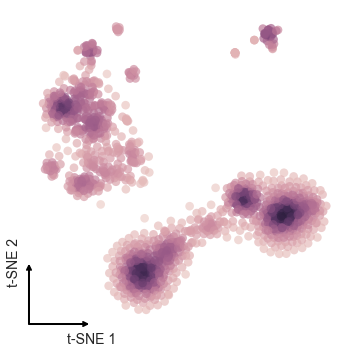

In [24]:
retina_tSNE = fcc_tSNE(retina.arcsinh_norm(), perplexity=30, seed=1)
retina_tSNE.plot()

In [25]:
np.savetxt(X=retina_tSNE.results, fname='dev/pymethods_out/retina_tSNE.csv', delimiter=',')

In [26]:
retina_tSNE.plot(color=retina.arcsinh_norm().sum(axis=1), save_to='images/retina_tSNE.png', figsize=(6,6))

In [27]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_tSNE.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_tSNE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['t-SNE'], final_distance_stats['Retina']['EMD']['t-SNE'], final_distance_stats['Retina']['KLD']['t-SNE'], final_distance_stats['Retina']['Knn Pres.']['t-SNE'] = mantel_stats[0], EMD, KLD, knn

R: 0.7739
EMD: 0.2165
KLD: 0.1366
Knn Pres.: 96.8218
CPU times: user 37.7 s, sys: 7.34 s, total: 45 s
Wall time: 45.5 s


CPU times: user 19 s, sys: 474 ms, total: 19.4 s
Wall time: 18.9 s


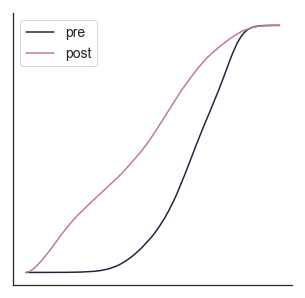

<Figure size 504x504 with 0 Axes>

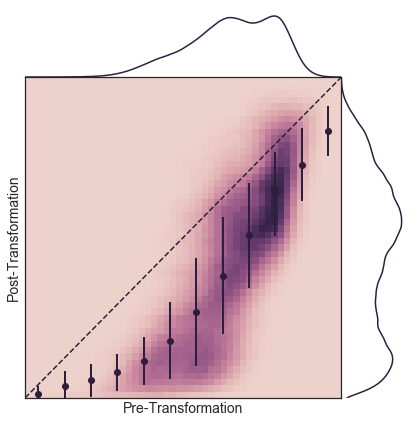

In [28]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_tSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_tSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

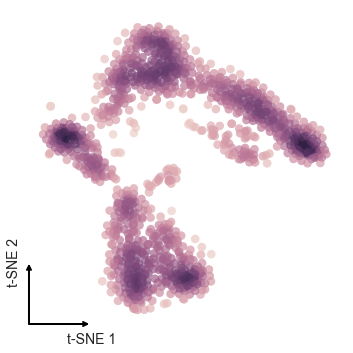

In [29]:
colon_tSNE = fcc_tSNE(colon.arcsinh_norm(), perplexity=30, seed=1)
colon_tSNE.plot()

In [30]:
np.savetxt(X=colon_tSNE.results, fname='dev/pymethods_out/colon_tSNE.csv', delimiter=',')

In [31]:
colon_tSNE.plot(color=colon.arcsinh_norm().sum(axis=1), save_to='images/colon_tSNE.png', figsize=(6,6))

In [32]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_tSNE.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_tSNE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['t-SNE'], final_distance_stats['Colon']['EMD']['t-SNE'], final_distance_stats['Colon']['KLD']['t-SNE'], final_distance_stats['Colon']['Knn Pres.']['t-SNE'] = mantel_stats[0], EMD, KLD, knn

R: 0.8816
EMD: 0.0822
KLD: 0.0516
Knn Pres.: 97.1733
CPU times: user 24.4 s, sys: 4.77 s, total: 29.2 s
Wall time: 29.7 s


CPU times: user 18.3 s, sys: 456 ms, total: 18.8 s
Wall time: 18.3 s


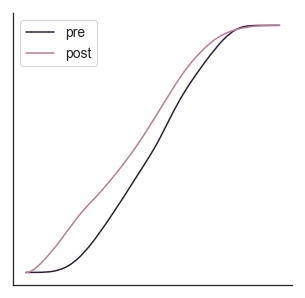

<Figure size 504x504 with 0 Axes>

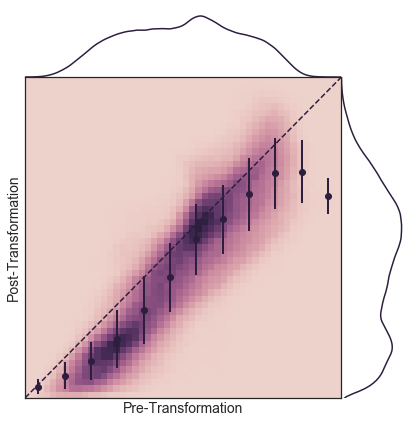

In [33]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_tSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_tSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# FIt-SNE
A workhorse technique for dimensionality reduction and visualization of scRNA-seq datasets, t-SNE performs a stochastic, non-linear transformation to project high-dimensional data into 2D in order to identify clustering and global structure. The FIt-SNE implementation is supposed to be faster and more efficient.  
Here, we will plug arcsinh-normalized counts data directly into t-SNE and compare results to the original, feature-selected dataset.

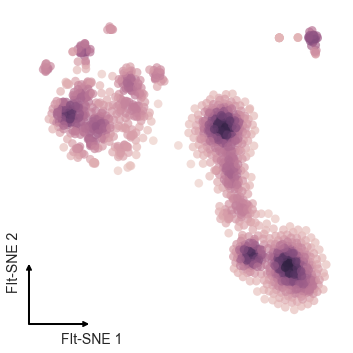

In [89]:
retina_FItSNE = fcc_FItSNE(retina.arcsinh_norm(), perplexity=30, seed=1)
retina_FItSNE.plot()

In [90]:
np.savetxt(X=retina_FItSNE.results, fname='dev/pymethods_out/retina_FItSNE.csv', delimiter=',')

In [91]:
retina_FItSNE.plot(color=retina.arcsinh_norm().sum(axis=1), save_to='images/retina_FItSNE.png', figsize=(6,6))

In [92]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_FItSNE.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_FItSNE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['FIt-SNE'], final_distance_stats['Retina']['EMD']['FIt-SNE'], final_distance_stats['Retina']['KLD']['FIt-SNE'], final_distance_stats['Retina']['Knn Pres.']['FIt-SNE'] = mantel_stats[0], EMD, KLD, knn

R: 0.782
EMD: 0.2708
KLD: 0.1576
Knn Pres.: 96.8063
CPU times: user 36.4 s, sys: 6.74 s, total: 43.2 s
Wall time: 43.2 s


CPU times: user 20.6 s, sys: 437 ms, total: 21 s
Wall time: 20.6 s


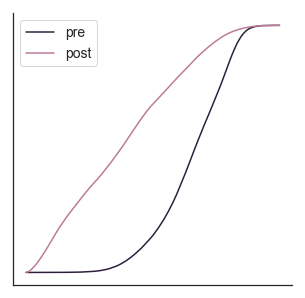

<Figure size 504x504 with 0 Axes>

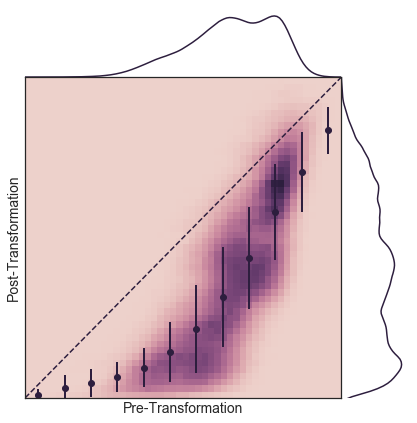

In [93]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_FItSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_FItSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

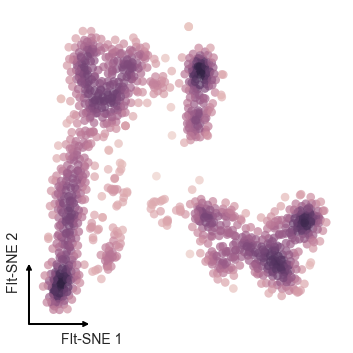

In [94]:
colon_FItSNE = fcc_FItSNE(colon.arcsinh_norm(), perplexity=30, seed=1)
colon_FItSNE.plot()

In [97]:
np.savetxt(X=colon_FItSNE.results, fname='dev/pymethods_out/colon_FItSNE.csv', delimiter=',')

In [98]:
colon_FItSNE.plot(color=colon.arcsinh_norm().sum(axis=1), save_to='images/colon_FItSNE.png', figsize=(6,6))

In [99]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_FItSNE.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_FItSNE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['FIt-SNE'], final_distance_stats['Colon']['EMD']['FIt-SNE'], final_distance_stats['Colon']['KLD']['FIt-SNE'], final_distance_stats['Colon']['Knn Pres.']['FIt-SNE'] = mantel_stats[0], EMD, KLD, knn

R: 0.8438
EMD: 0.0691
KLD: 0.0582
Knn Pres.: 97.148
CPU times: user 24.4 s, sys: 4.89 s, total: 29.3 s
Wall time: 29.4 s


CPU times: user 18.7 s, sys: 497 ms, total: 19.2 s
Wall time: 18.9 s


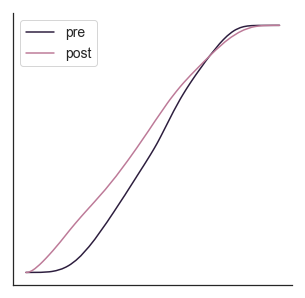

<Figure size 504x504 with 0 Axes>

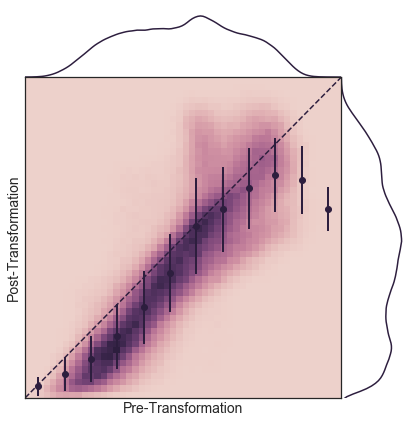

In [100]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_FItSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_FItSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# UMAP
Another popular method for low-dimensional projection of scRNA-seq datasets, UMAP creates high-dimensional manifolds that describe the structure of the dataset.  
Here, we will plug arcsinh-normalized counts data directly into UMAP and compare results to the original, feature-selected dataset.

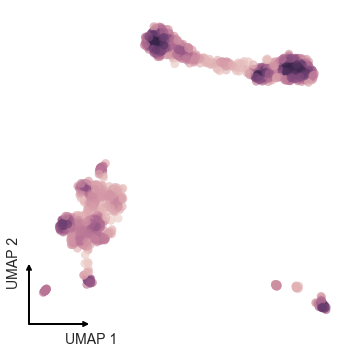

In [34]:
retina_UMAP = fcc_UMAP(retina.arcsinh_norm(), perplexity=30, seed=1)
retina_UMAP.plot()

In [35]:
np.savetxt(X=retina_UMAP.results, fname='dev/pymethods_out/retina_UMAP.csv', delimiter=',')

In [36]:
retina_UMAP.plot(color=retina.arcsinh_norm().sum(axis=1), save_to='images/retina_UMAP.png', figsize=(6,6))

In [37]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_UMAP.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_UMAP.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['UMAP'], final_distance_stats['Retina']['EMD']['UMAP'], final_distance_stats['Retina']['KLD']['UMAP'], final_distance_stats['Retina']['Knn Pres.']['UMAP'] = mantel_stats[0], EMD, KLD, knn

R: 0.7269
EMD: 0.2247
KLD: 0.2474
Knn Pres.: 96.6672
CPU times: user 37.1 s, sys: 6.92 s, total: 44 s
Wall time: 44.1 s


CPU times: user 18.5 s, sys: 412 ms, total: 18.9 s
Wall time: 18.2 s


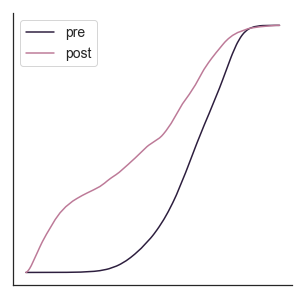

<Figure size 504x504 with 0 Axes>

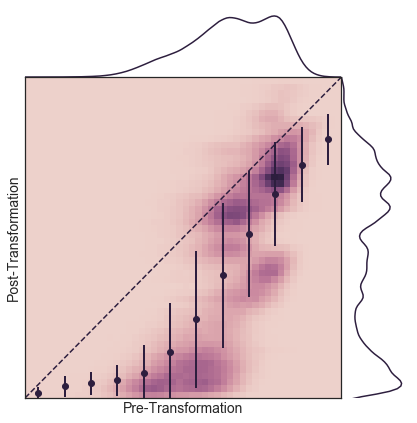

In [38]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_UMAP_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_UMAP_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

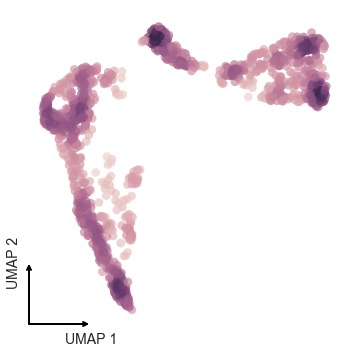

In [39]:
colon_UMAP = fcc_UMAP(colon.arcsinh_norm(), perplexity=30, seed=1)
colon_UMAP.plot()

In [40]:
np.savetxt(X=colon_UMAP.results, fname='dev/pymethods_out/colon_UMAP.csv', delimiter=',')

In [41]:
colon_UMAP.plot(color=colon.arcsinh_norm().sum(axis=1), save_to='images/colon_UMAP.png', figsize=(6,6))

In [42]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_UMAP.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_UMAP.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['UMAP'], final_distance_stats['Colon']['EMD']['UMAP'], final_distance_stats['Colon']['KLD']['UMAP'], final_distance_stats['Colon']['Knn Pres.']['UMAP'] = mantel_stats[0], EMD, KLD, knn

R: 0.8002
EMD: 0.0936
KLD: 0.0998
Knn Pres.: 97.1171
CPU times: user 23.6 s, sys: 4.62 s, total: 28.3 s
Wall time: 28.4 s


CPU times: user 18.5 s, sys: 409 ms, total: 18.9 s
Wall time: 18.3 s


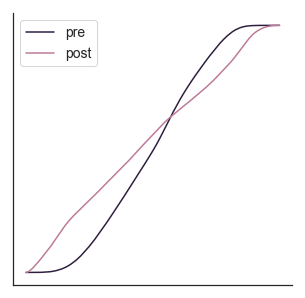

<Figure size 504x504 with 0 Axes>

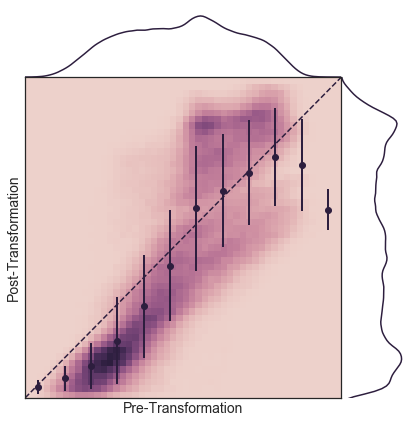

In [43]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_UMAP_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_UMAP_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# ZIFA
This method uses the zero-inflated negative binomial distribution to reduce RNA counts data to lower dimensions.  
Here, we will plug arcsinh-normalized counts data directly into ZIFA and compare results to the original, feature-selected dataset.

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1326, D = 489, K = 2, n_blocks = 1
Block sizes [489]
Param change below threshold 1.000e-02 after 6 iterations


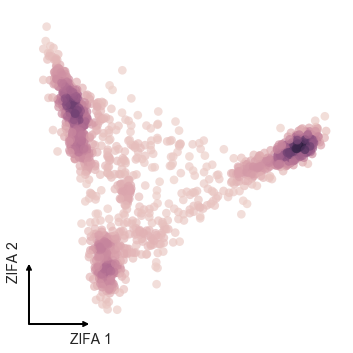

In [44]:
retina_ZIFA = fcc_ZIFA(retina.log2_norm(), K=2)
retina_ZIFA.plot()

In [45]:
np.savetxt(X=retina_ZIFA.results, fname='dev/pymethods_out/retina_ZIFA.csv', delimiter=',')

In [46]:
retina_ZIFA.plot(color=retina.arcsinh_norm().sum(axis=1), save_to='images/retina_ZIFA.png', figsize=(6,6))

In [47]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='log2'), post=retina_ZIFA.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='log2'), post=retina_ZIFA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['ZIFA'], final_distance_stats['Retina']['EMD']['ZIFA'], final_distance_stats['Retina']['KLD']['ZIFA'], final_distance_stats['Retina']['Knn Pres.']['ZIFA'] = mantel_stats[0], EMD, KLD, knn

R: 0.4224
EMD: 0.1539
KLD: 0.1918
Knn Pres.: 96.3503
CPU times: user 37.6 s, sys: 7.69 s, total: 45.3 s
Wall time: 45.5 s


/Users/cody/git/furry-couscous/fcc_utils.py:156: RuntimeWarning: invalid value encountered in true_divide
  mean = sy / n
/Users/cody/git/furry-couscous/fcc_utils.py:157: RuntimeWarning: invalid value encountered in true_divide
  std = np.sqrt(sy2/n - mean*mean)


CPU times: user 18.4 s, sys: 403 ms, total: 18.8 s
Wall time: 18.1 s


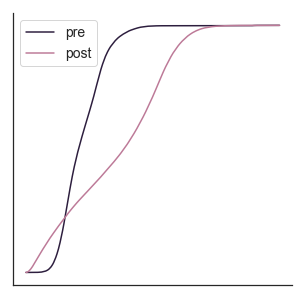

<Figure size 504x504 with 0 Axes>

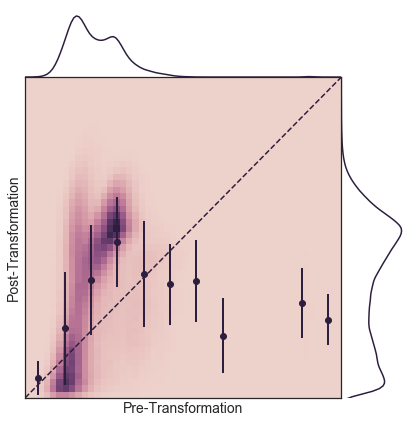

In [48]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_ZIFA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_ZIFA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1117, D = 496, K = 2, n_blocks = 1
Block sizes [496]
Param change below threshold 1.000e-02 after 2 iterations


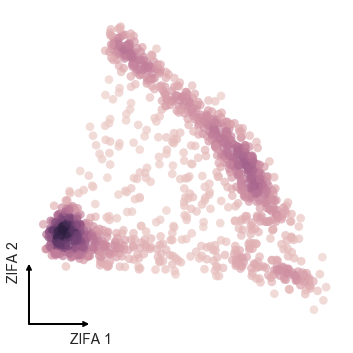

In [49]:
colon_ZIFA = fcc_ZIFA(colon.log2_norm(), K=2)
colon_ZIFA.plot()

In [50]:
np.savetxt(X=colon_ZIFA.results, fname='dev/pymethods_out/colon_ZIFA.csv', delimiter=',')

In [51]:
colon_ZIFA.plot(color=colon.arcsinh_norm().sum(axis=1), save_to='images/colon_ZIFA.png', figsize=(6,6))

In [52]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='log2'), post=colon_ZIFA.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='log2'), post=colon_ZIFA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['ZIFA'], final_distance_stats['Colon']['EMD']['ZIFA'], final_distance_stats['Colon']['KLD']['ZIFA'], final_distance_stats['Colon']['Knn Pres.']['ZIFA'] = mantel_stats[0], EMD, KLD, knn

R: 0.6099
EMD: 0.1329
KLD: 0.1354
Knn Pres.: 96.1399
CPU times: user 24.3 s, sys: 5.26 s, total: 29.5 s
Wall time: 29.6 s


CPU times: user 19.6 s, sys: 426 ms, total: 20 s
Wall time: 19.5 s


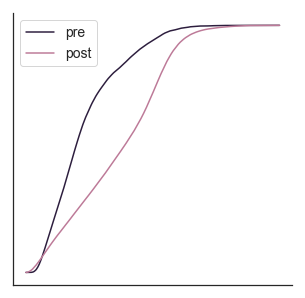

<Figure size 504x504 with 0 Axes>

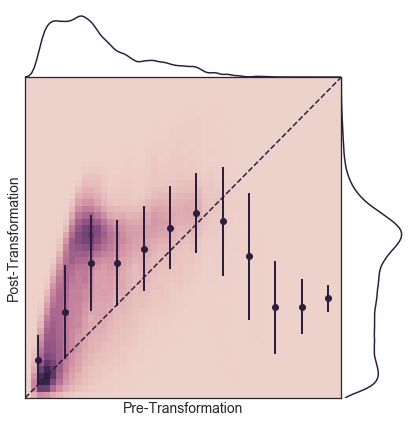

In [53]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_ZIFA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_ZIFA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# DCA
This method uses a deep count autoencoder to reduce RNA counts data to lower dimensions.  
Here, we will plug counts data directly into DCA and compare results to the original, feature-selected dataset.

In [54]:
%time retina_DCA = fcc_DCA(retina.counts, n_threads=4, norm=False, seed=18, hidden_size=(64,2,64), mode='latent')

Using TensorFlow backend.


DCA: Successfully preprocessed 500 genes and 1326 cells.
Instructions for updating:
Colocations handled automatically by placer.


/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/kopt/config.py:60: YAMLLoadWarning: 
  *** Calling yaml.load() without Loader=... is deprecated.
  *** The default Loader is unsafe.
  *** Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))
2019-05-30 14:33:55,311 [WARNING] From /Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


2019-05-30 14:33:56,375 [WARNING] From /Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 32.1 s, sys: 3.98 s, total: 36.1 s
Wall time: 24 s


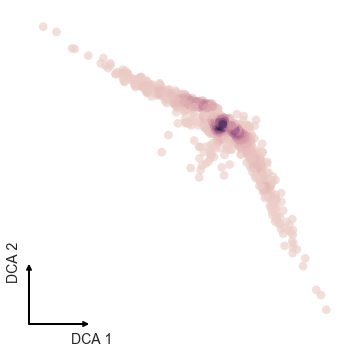

In [55]:
retina_DCA.plot()

In [56]:
np.savetxt(X=retina_DCA.results, fname='dev/pymethods_out/retina_DCA.csv', delimiter=',')

In [57]:
retina_DCA.plot(color=retina.arcsinh_norm().sum(axis=1), save_to='images/retina_DCA.png', figsize=(6,6))

In [58]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_DCA.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_DCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['DCA'], final_distance_stats['Retina']['EMD']['DCA'], final_distance_stats['Retina']['KLD']['DCA'], final_distance_stats['Retina']['Knn Pres.']['DCA'] = mantel_stats[0], EMD, KLD, knn

R: 0.745
EMD: 0.0276
KLD: 0.1722
Knn Pres.: 96.411
CPU times: user 39.7 s, sys: 7.86 s, total: 47.5 s
Wall time: 49.3 s


CPU times: user 19 s, sys: 413 ms, total: 19.4 s
Wall time: 18.7 s


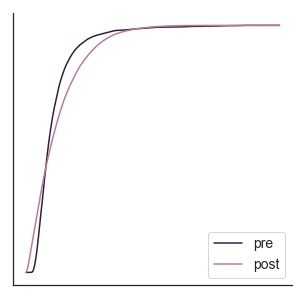

<Figure size 504x504 with 0 Axes>

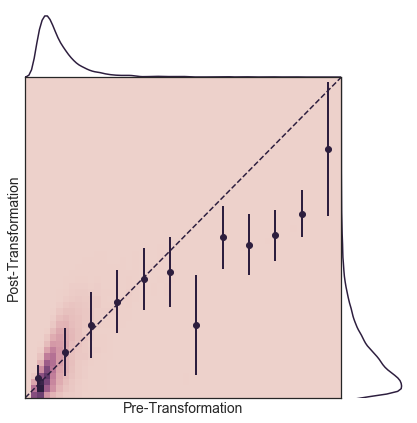

In [59]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_DCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_DCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [60]:
%time colon_DCA = fcc_DCA(colon.counts, n_threads=4, norm=False, seed=18, hidden_size=(64,2,64), mode='latent')

DCA: Successfully preprocessed 500 genes and 1117 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 25.6 s, sys: 3.17 s, total: 28.7 s
Wall time: 17.8 s


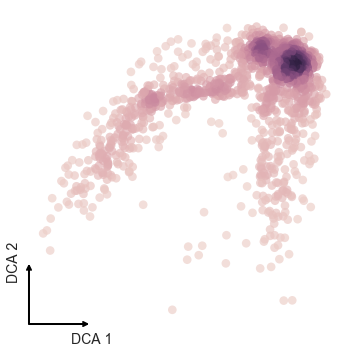

In [61]:
colon_DCA.plot()

In [62]:
np.savetxt(X=colon_DCA.results, fname='dev/pymethods_out/colon_DCA.csv', delimiter=',')

In [63]:
colon_DCA.plot(color=colon.arcsinh_norm().sum(axis=1), save_to='images/colon_DCA.png', figsize=(6,6))

In [64]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_DCA.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_DCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['DCA'], final_distance_stats['Colon']['EMD']['DCA'], final_distance_stats['Colon']['KLD']['DCA'], final_distance_stats['Colon']['Knn Pres.']['DCA'] = mantel_stats[0], EMD, KLD, knn

R: 0.4957
EMD: 0.1543
KLD: 0.2146
Knn Pres.: 95.9836
CPU times: user 26.8 s, sys: 5.82 s, total: 32.7 s
Wall time: 33.6 s


CPU times: user 20.1 s, sys: 533 ms, total: 20.6 s
Wall time: 20.8 s


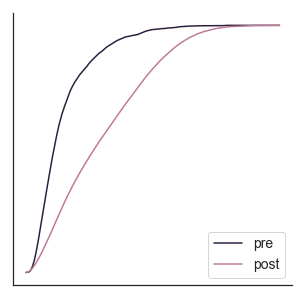

<Figure size 504x504 with 0 Axes>

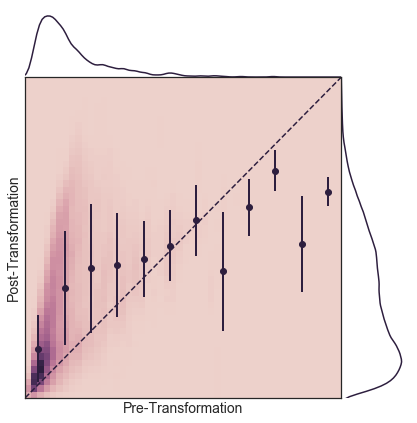

In [65]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_DCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_DCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# sc-VI
Here, we will plug counts data directly into sc-VI and compare results to the original, feature-selected dataset.

In [66]:
from scvi.dataset import CsvDataset, GeneExpressionDataset
import urllib
from scvi.models import *
from scvi.inference import UnsupervisedTrainer
use_batches=False

In [67]:
# Loading a local dataset into scVI
retina_scVI = CsvDataset('GSM1626793_P14Retina_1.processed.tsv', save_path='inputs/', new_n_genes=500, gene_by_cell=False, sep='\t')

File inputs/GSM1626793_P14Retina_1.processed.tsv already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [68]:
vae = VAE(retina_scVI.nb_genes, n_batch=retina_scVI.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              retina_scVI,
                              train_size=0.75,
                              use_cuda=True,
                              frequency=5)
trainer.train(n_epochs=400, lr=1e-3)

training: 100%|███████████████████████████████████████████████████████████████████████████████████| 400/400 [01:44<00:00,  3.65it/s]


In [69]:
full = trainer.create_posterior(trainer.model, retina_scVI, indices=np.arange(len(retina_scVI)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

In [70]:
retina_scVI = DR(latent=latent.astype('double'), name='scVI')

In [71]:
np.savetxt(X=retina_scVI.results, fname='dev/pymethods_out/retina_scVI.csv', delimiter=',')

Perform t-SNE on scVI output to visualize

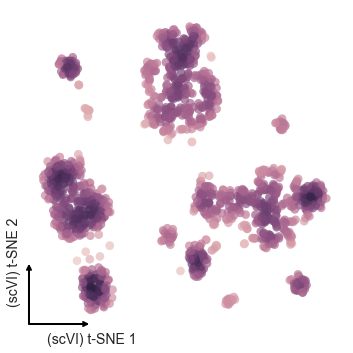

CPU times: user 13.6 s, sys: 78.4 ms, total: 13.7 s
Wall time: 13.6 s


In [74]:
%%time
retina_scVI_tSNE = fcc_tSNE(retina_scVI.results, perplexity=30, seed=18)
retina_scVI_tSNE.name = '(scVI) t-SNE'
retina_scVI_tSNE.plot()

In [75]:
np.savetxt(X=retina_scVI_tSNE.results, fname='dev/pymethods_out/retina_scVI_tSNE.csv', delimiter=',')

In [76]:
retina_scVI_tSNE.plot(color=retina.arcsinh_norm().sum(axis=1), save_to='images/retina_scVI.png', figsize=(6,6))

In [77]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_scVI.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_scVI.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['scVI'], final_distance_stats['Retina']['EMD']['scVI'], final_distance_stats['Retina']['KLD']['scVI'], final_distance_stats['Retina']['Knn Pres.']['scVI'] = mantel_stats[0], EMD, KLD, knn

R: 0.2454
EMD: 0.3371
KLD: 0.2054
Knn Pres.: 96.1521
CPU times: user 40.9 s, sys: 7.12 s, total: 48 s
Wall time: 48.2 s


CPU times: user 19.3 s, sys: 427 ms, total: 19.7 s
Wall time: 19.2 s


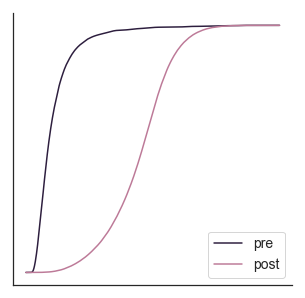

<Figure size 504x504 with 0 Axes>

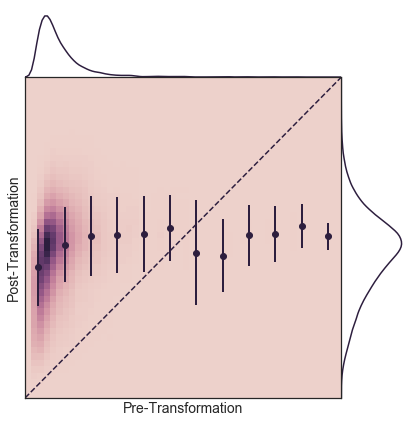

In [78]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_scVI_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_scVI_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [79]:
# Loading a local dataset into scVI
colon_scVI = CsvDataset('GSM2743164_rep1_colon_rnaseq.processed.tsv', save_path='inputs/', new_n_genes=500, gene_by_cell=False, sep='\t')

File inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [80]:
vae = VAE(colon_scVI.nb_genes, n_batch=colon_scVI.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              colon_scVI,
                              train_size=0.75,
                              use_cuda=True,
                              frequency=5)
trainer.train(n_epochs=400, lr=1e-3)

training: 100%|███████████████████████████████████████████████████████████████████████████████████| 400/400 [01:28<00:00,  4.20it/s]


In [81]:
full = trainer.create_posterior(trainer.model, colon_scVI, indices=np.arange(len(colon_scVI)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

In [82]:
colon_scVI = DR(latent=latent.astype('double'), name='scVI')

In [83]:
np.savetxt(X=colon_scVI.results, fname='dev/pymethods_out/colon_scVI.csv', delimiter=',')

Perform t-SNE on scVI output to visualize

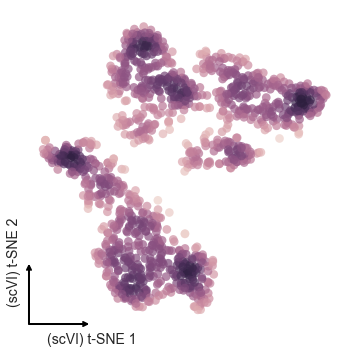

CPU times: user 12.4 s, sys: 77.4 ms, total: 12.4 s
Wall time: 12.3 s


In [84]:
%%time
colon_scVI_tSNE = fcc_tSNE(colon_scVI.results, perplexity=30, seed=18)
colon_scVI_tSNE.name = '(scVI) t-SNE'
colon_scVI_tSNE.plot()

In [85]:
np.savetxt(X=colon_scVI_tSNE.results, fname='dev/pymethods_out/colon_scVI_tSNE.csv', delimiter=',')

In [86]:
colon_scVI_tSNE.plot(color=colon.arcsinh_norm().sum(axis=1), save_to='images/colon_scVI.png', figsize=(6,6))

In [87]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_scVI.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_scVI.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['scVI'], final_distance_stats['Colon']['EMD']['scVI'], final_distance_stats['Colon']['KLD']['scVI'], final_distance_stats['Colon']['Knn Pres.']['scVI'] = mantel_stats[0], EMD, KLD, knn

R: 0.391
EMD: 0.2772
KLD: 0.2107
Knn Pres.: 95.6696
CPU times: user 25.3 s, sys: 3.77 s, total: 29.1 s
Wall time: 29.3 s


CPU times: user 17.8 s, sys: 338 ms, total: 18.1 s
Wall time: 17.3 s


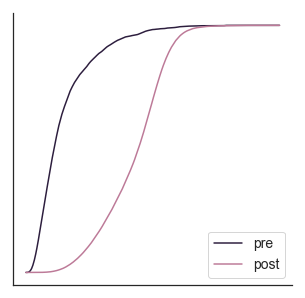

<Figure size 504x504 with 0 Axes>

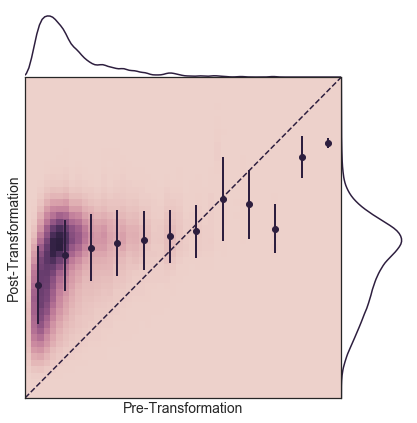

In [88]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_scVI_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_scVI_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# scvis
Here, we will plug counts data directly into scvis and compare results to the original, feature-selected dataset.

In [9]:
retina_scvis = DR.from_file(datafile='scvis_out/retina/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv',
                            labels=[0,0], name='scvis')

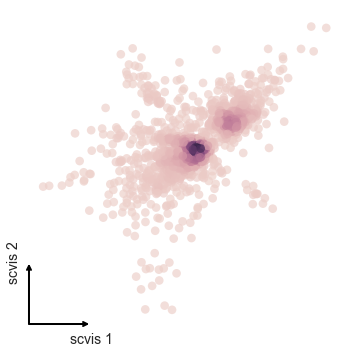

In [10]:
retina_scvis.plot()

In [11]:
retina_scvis.plot(color=retina.arcsinh_norm().sum(axis=1), save_to='../images/retina_scvis.png', figsize=(6,6))

In [12]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_scvis.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_scvis.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['scvis'], final_distance_stats['Retina']['EMD']['scvis'], final_distance_stats['Retina']['KLD']['scvis'], final_distance_stats['Retina']['Knn Pres.']['scvis'] = mantel_stats[0], EMD, KLD, knn

R: 0.7997
EMD: 0.0619
KLD: 0.0779
Knn Pres.: 97.7827
CPU times: user 38.5 s, sys: 7.39 s, total: 45.9 s
Wall time: 46.1 s


CPU times: user 17.6 s, sys: 370 ms, total: 18 s
Wall time: 17.3 s


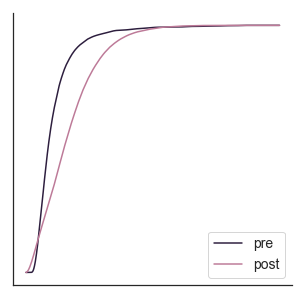

<Figure size 504x504 with 0 Axes>

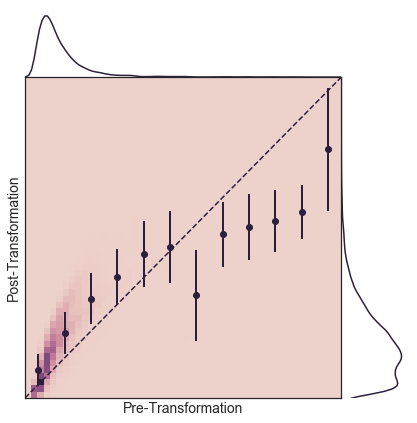

In [13]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_scvis_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_scvis_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [14]:
colon_scvis = DR.from_file(datafile='scvis_out/colon/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv',
                           labels=[0,0], name='scvis')

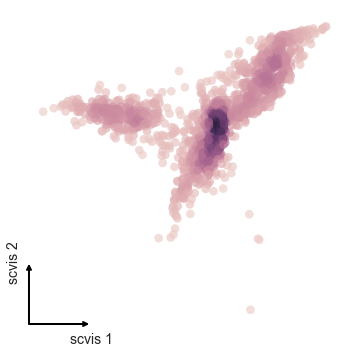

In [15]:
colon_scvis.plot()

In [16]:
colon_scvis.plot(color=colon.arcsinh_norm().sum(axis=1), save_to='../images/colon_scvis.png', figsize=(6,6))

In [17]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_scvis.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_scvis.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['scvis'], final_distance_stats['Colon']['EMD']['scvis'], final_distance_stats['Colon']['KLD']['scvis'], final_distance_stats['Colon']['Knn Pres.']['scvis'] = mantel_stats[0], EMD, KLD, knn

R: 0.77
EMD: 0.1175
KLD: 0.0963
Knn Pres.: 97.9649
CPU times: user 24 s, sys: 4.15 s, total: 28.1 s
Wall time: 28.1 s


CPU times: user 17.6 s, sys: 356 ms, total: 17.9 s
Wall time: 17.1 s


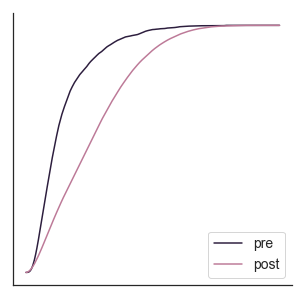

<Figure size 504x504 with 0 Axes>

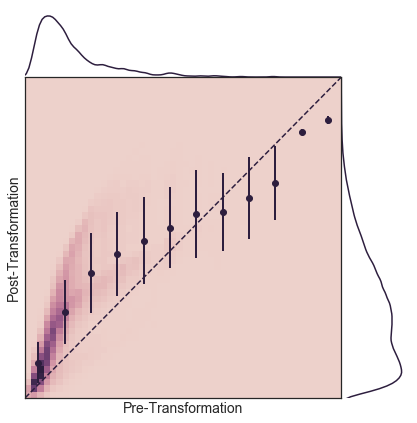

In [18]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_scvis_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_scvis_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# SIMLR
This method builds cell-cell similarity matrices to predict cluster number and assign cells to clusters based on similarity.
First, read in the `F` construct that consists of a c-dimensional output of length `n_cells`, where c is the number of expected clusters passed to SIMLR.  
Here, c was the number of clusters determined by Seurat Louvain algorithm.

In [101]:
retina_SIMLR = DR.from_file('dev/Rmethods_out/retina_SIMLR_F.csv', name='SIMLR', labels=[None,0]) # read in low-dim space for comparison

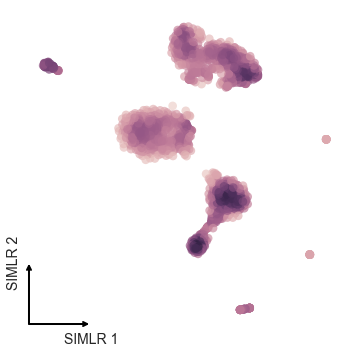

In [102]:
retina_SIMLR.plot()

In [109]:
retina_SIMLR.plot(color=retina.arcsinh_norm().sum(axis=1), save_to='images/retina_SIMLR.png', figsize=(6,6))

In [103]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_SIMLR.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_SIMLR.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['SIMLR'], final_distance_stats['Retina']['EMD']['SIMLR'], final_distance_stats['Retina']['KLD']['SIMLR'], final_distance_stats['Retina']['Knn Pres.']['SIMLR'] = mantel_stats[0], EMD, KLD, knn

R: 0.526
EMD: 0.3275
KLD: 0.1824
Knn Pres.: 97.2329
CPU times: user 41 s, sys: 6.86 s, total: 47.9 s
Wall time: 58.5 s


CPU times: user 21.8 s, sys: 431 ms, total: 22.2 s
Wall time: 26.5 s


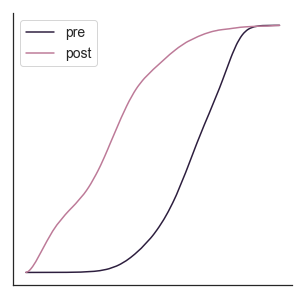

<Figure size 504x504 with 0 Axes>

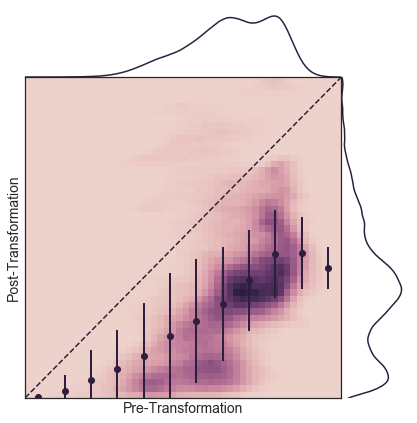

In [104]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_SIMLR_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_SIMLR_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [105]:
colon_SIMLR = DR.from_file('dev/Rmethods_out/colon_SIMLR_F.csv', name='SIMLR', labels=[None,0]) # read in low-dim space for comparison

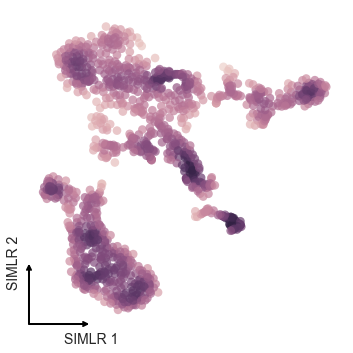

In [106]:
colon_SIMLR.plot()

In [110]:
colon_SIMLR.plot(color=colon.arcsinh_norm().sum(axis=1), save_to='images/colon_SIMLR.png', figsize=(6,6))

In [107]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_SIMLR.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_SIMLR.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['SIMLR'], final_distance_stats['Colon']['EMD']['SIMLR'], final_distance_stats['Colon']['KLD']['SIMLR'], final_distance_stats['Colon']['Knn Pres.']['SIMLR'] = mantel_stats[0], EMD, KLD, knn

R: 0.7662
EMD: 0.0849
KLD: 0.0742
Knn Pres.: 96.8255
CPU times: user 27.1 s, sys: 4.44 s, total: 31.6 s
Wall time: 38.9 s


CPU times: user 21.8 s, sys: 413 ms, total: 22.2 s
Wall time: 27.3 s


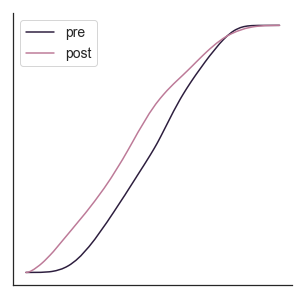

<Figure size 504x504 with 0 Axes>

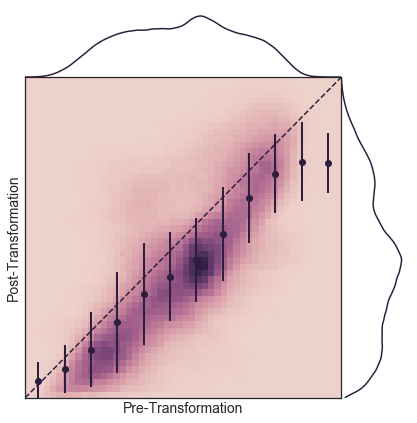

In [108]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_SIMLR_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_SIMLR_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
### ZINB-WAVE

In [111]:
retina_ZINBWAVE = DR.from_file('dev/Rmethods_out/retina_ZINB-WAVE.csv', name='ZINB-WaVE', labels=[None,0])

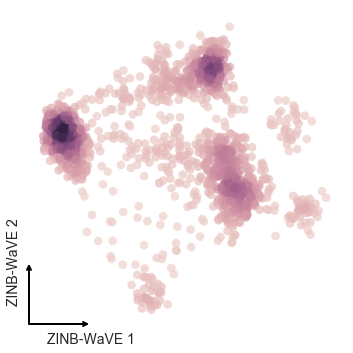

In [112]:
retina_ZINBWAVE.plot()

In [113]:
retina_ZINBWAVE.plot(color=retina.arcsinh_norm().sum(axis=1), save_to='images/retina_ZINBWAVE.png', figsize=(6,6))

In [114]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_ZINBWAVE.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_ZINBWAVE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['ZINB-WaVE'], final_distance_stats['Retina']['EMD']['ZINB-WaVE'], final_distance_stats['Retina']['KLD']['ZINB-WaVE'], final_distance_stats['Retina']['Knn Pres.']['ZINB-WaVE'] = mantel_stats[0], EMD, KLD, knn

R: 0.2929
EMD: 0.2695
KLD: 0.2943
Knn Pres.: 96.1098
CPU times: user 44.3 s, sys: 8.52 s, total: 52.8 s
Wall time: 1min 12s


CPU times: user 21.4 s, sys: 444 ms, total: 21.8 s
Wall time: 24.8 s


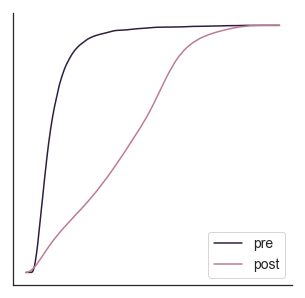

<Figure size 504x504 with 0 Axes>

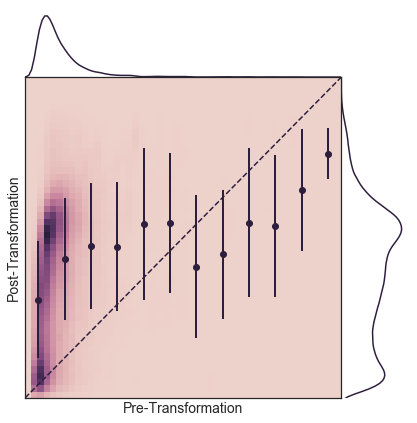

In [115]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_ZINBWAVE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_ZINBWAVE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [116]:
colon_ZINBWAVE = DR.from_file('dev/Rmethods_out/colon_ZINB-WAVE.csv', name='ZINB-WaVE', labels=[None,0])

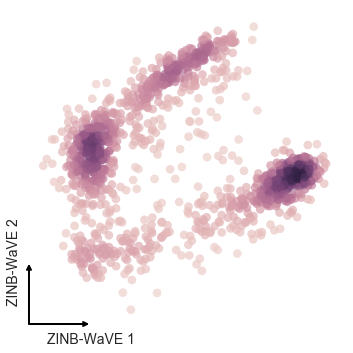

In [117]:
colon_ZINBWAVE.plot()

In [118]:
colon_ZINBWAVE.plot(color=colon.arcsinh_norm().sum(axis=1), save_to='images/colon_ZINBWAVE.png', figsize=(6,6))

In [119]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_ZINBWAVE.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_ZINBWAVE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['ZINB-WaVE'], final_distance_stats['Colon']['EMD']['ZINB-WaVE'], final_distance_stats['Colon']['KLD']['ZINB-WaVE'], final_distance_stats['Colon']['Knn Pres.']['ZINB-WaVE'] = mantel_stats[0], EMD, KLD, knn

R: 0.36
EMD: 0.262
KLD: 0.2622
Knn Pres.: 95.7974
CPU times: user 27.8 s, sys: 4.08 s, total: 31.9 s
Wall time: 37.7 s


CPU times: user 21.1 s, sys: 415 ms, total: 21.5 s
Wall time: 25.5 s


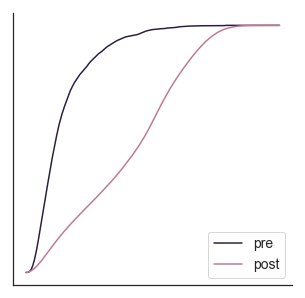

<Figure size 504x504 with 0 Axes>

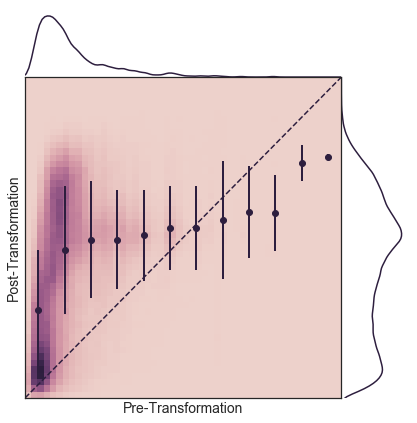

In [120]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_ZINBWAVE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_ZINBWAVE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
### GLM-PCA

In [121]:
retina_GLMPCA = DR.from_file('dev/Rmethods_out/retina_GLM-PCA.csv', name='GLM-PC', labels=[None,0])

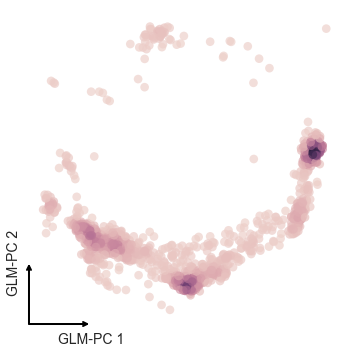

In [122]:
retina_GLMPCA.plot()

In [123]:
retina_GLMPCA.plot(color=retina.arcsinh_norm().sum(axis=1), save_to='images/retina_GLMPCA.png', figsize=(6,6))

In [125]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_GLMPCA.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_GLMPCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['GLM-PCA'], final_distance_stats['Retina']['EMD']['GLM-PCA'], final_distance_stats['Retina']['KLD']['GLM-PCA'], final_distance_stats['Retina']['Knn Pres.']['GLM-PCA'] = mantel_stats[0], EMD, KLD, knn

R: 0.2704
EMD: 0.2516
KLD: 0.3752
Knn Pres.: 96.0884
CPU times: user 42.4 s, sys: 6.75 s, total: 49.1 s
Wall time: 1min


CPU times: user 21.6 s, sys: 427 ms, total: 22 s
Wall time: 25.9 s


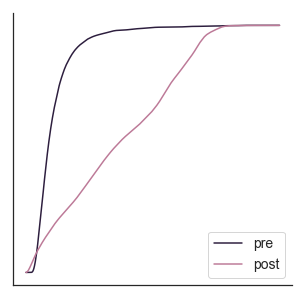

<Figure size 504x504 with 0 Axes>

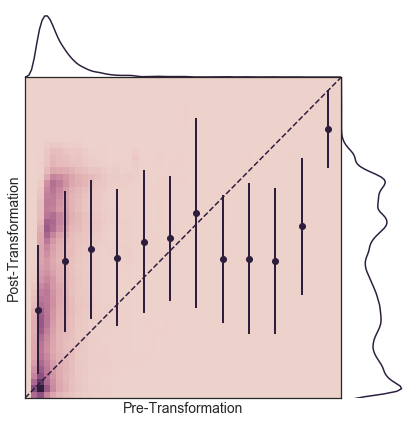

In [126]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_GLMPCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_GLMPCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [127]:
colon_GLMPCA = DR.from_file('dev/Rmethods_out/colon_GLM-PCA.csv', name='GLM-PC', labels=[None,0])

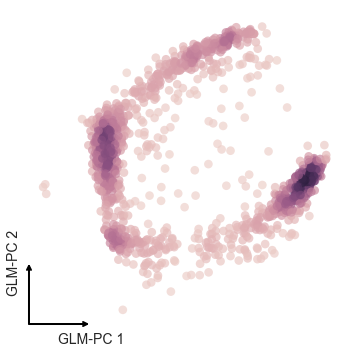

In [128]:
colon_GLMPCA.plot()

In [129]:
colon_GLMPCA.plot(color=colon.arcsinh_norm().sum(axis=1), save_to='images/colon_GLMPCA.png', figsize=(6,6))

In [130]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_GLMPCA.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_GLMPCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['GLM-PCA'], final_distance_stats['Colon']['EMD']['GLM-PCA'], final_distance_stats['Colon']['KLD']['GLM-PCA'], final_distance_stats['Colon']['Knn Pres.']['GLM-PCA'] = mantel_stats[0], EMD, KLD, knn

R: 0.3325
EMD: 0.244
KLD: 0.2779
Knn Pres.: 95.7796
CPU times: user 29.1 s, sys: 4.12 s, total: 33.3 s
Wall time: 39.4 s


CPU times: user 21.7 s, sys: 380 ms, total: 22 s
Wall time: 25.5 s


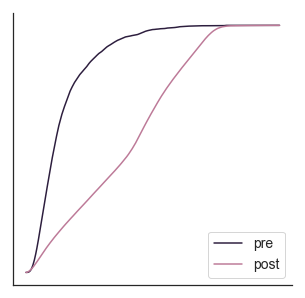

<Figure size 504x504 with 0 Axes>

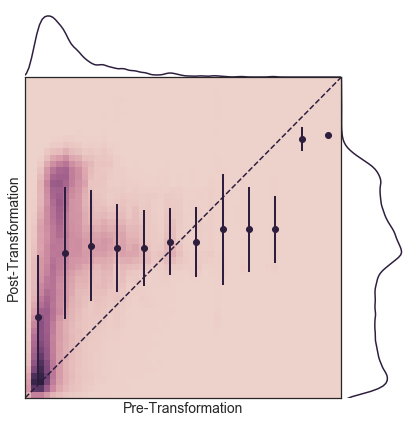

In [131]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_GLMPCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_GLMPCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
### Summary Metrics

In [181]:
retina_sum = pd.DataFrame(final_distance_stats['Retina'])
retina_sum = retina_sum.sort_values(by='R')
retina_sum = retina_sum.reindex(['EMD','KLD','R','Knn Pres.'], axis=1)
retina_sum.to_csv('retina_global_metrics.csv')

In [28]:
retina_sum = retina_sum.drop('KLD', axis=1) # dropping KL divergence

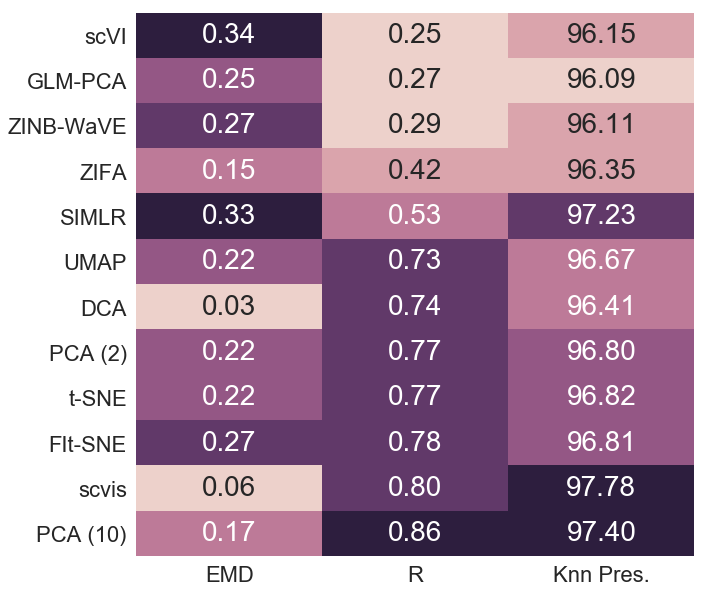

In [30]:
retina_norm=(retina_sum-retina_sum.mean())/retina_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
sns.heatmap(retina_norm, annot=retina_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)
plt.savefig(fname='../images/retina_global_metrics.png', transparent=True, bbox_inches='tight')

In [183]:
colon_sum = pd.DataFrame(final_distance_stats['Colon'])
colon_sum = colon_sum.sort_values(by='R')
colon_sum = colon_sum.reindex(['EMD','KLD','R','Knn Pres.'], axis=1)
colon_sum.to_csv('colon_global_metrics.csv')

In [33]:
colon_sum = colon_sum.drop('KLD', axis=1)

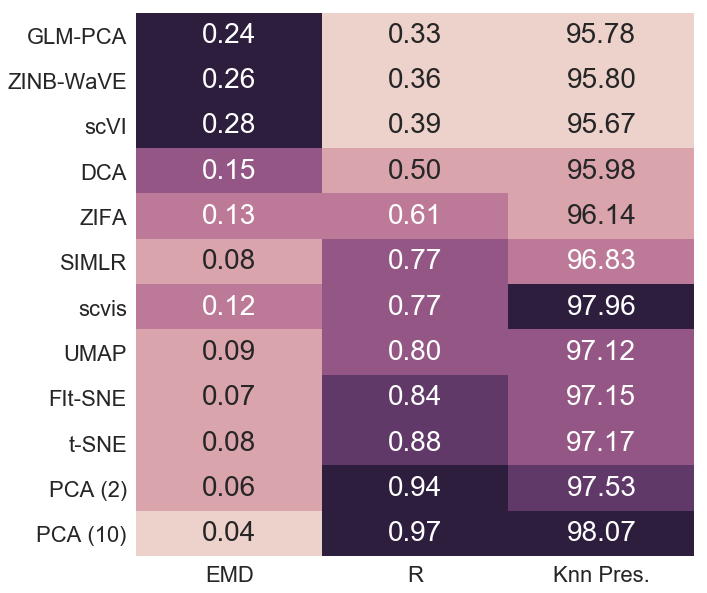

In [34]:
colon_norm=(colon_sum-colon_sum.mean())/colon_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
sns.heatmap(colon_norm, annot=colon_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)
plt.savefig(fname='../images/colon_global_metrics.png', transparent=True, bbox_inches='tight')